In [142]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [168]:
import random
random.seed(1)
# base station location
base_X = 25
base_Y = -100
# transmission energy and receive energy J/bit
ETx = 50*0.000000001
ERc = ETx
# amplification coefficientds J/bit/m^2
epsilon_amp = 10*0.000000000001
# number of clusters
num_clusters = 5
# number of nodes
num_nodes = 100
# initial energy of one node
energy = 0.5
# size of a packet
packet_bit = 2000
# aggregation energy
aggr = 5*0.000000001
# gather x bits together and aggregate them into 0.3 * x bits
aggr_rate = 0.2
# P and 1/P calculating threshould
P = num_clusters / (num_nodes * 1.0)
one_by_P = num_nodes // num_clusters

In [144]:
# cluster class
class Cluster:
    def __init__(self):
        # nodes in one cluster
        self.nodes = []
        # cluster head, type (node)
        self.head = None
        # number of bits awaiting aggregation
        self.bits = 0
    
    # add one node into the cluster
    def add(self, node):
        self.nodes.append(node)
      
    # tell whether the node is the cluster head
    def is_head(self, node):
        return node == self.head
    
    # quick calculation of the square of distance between one node and the cluster head
    def dis(self, node):
        return distance(node.X, self.head.X, node.Y, self.head.Y)

In [145]:
# square of distance instead of distance
def distance(x_1, x_2, y_1, y_2):
    return (x_1 - x_2)**2 + (y_1 - y_2)**2

In [146]:
def T(r):
    #print(P, one_by_P, r, P / (1 - P * (r % one_by_P)))
    return P / (1 - P * (r % one_by_P))

In [160]:
import random

class Node:
    def __init__(self, x, y):
        # (X,Y)
        self.X = x
        self.Y = y
        # remaining energy
        self.energy = energy
        # false means the nodes alive, otherwise dead
        self.die = False
        self.last = -1
        self.cluster = None
    
    def elect(self, r, clusters):
        self.cluster = None
        if r % one_by_P == 0:
            self.last = -1
        if (self.last == -1 or self.last + one_by_P <= r % one_by_P) and not self.die:
            if random.uniform (0,1) <= T(r):
                cluster = Cluster()
                cluster.add(self)
                cluster.head = self
                clusters.append(cluster)
                self.last = r
                self.cluster = cluster
                #print(r, len(clusters))
    
    def select(self, r, clusters):
        if self.cluster != None:
            return
        min_dis = 100000000
        cluster = -1
        for i in range(len(clusters)):
            if min_dis > clusters[i].dis(self):
                cluster = i
                min_dis = clusters[i].dis(self)
        #print(len(clusters), cluster)
        if cluster == -1:
            return
        clusters[cluster].add(self)
        self.cluster = clusters[cluster]
    
    def send(self):
        if self.cluster.is_head(self):
            if self.cluster.bits == 0:
                transmission = ETx * packet_bit
                amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification)
            else:
                transmission = ETx * aggr_rate * (packet_bit + self.cluster.bits)
                amplification = epsilon_amp * aggr_rate * (packet_bit + self.cluster.bits) * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification + aggr:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification + aggr)
        else:
            if self.cluster.head.die:
                self.die = True
                return
            transmission = ETx * packet_bit
            amplification = epsilon_amp * packet_bit * self.cluster.dis(self)
            if self.energy < transmission + amplification:
                self.die = True
            else:
                self.energy -= (transmission + amplification)
            receive = ERc * packet_bit
            self.cluster.head.energy -= receive
            self.cluster.bits += packet_bit

In [148]:
Xs = uniform.rvs(loc=0, scale=50, size=num_nodes)
Ys = uniform.rvs(loc=0, scale=50, size=num_nodes)

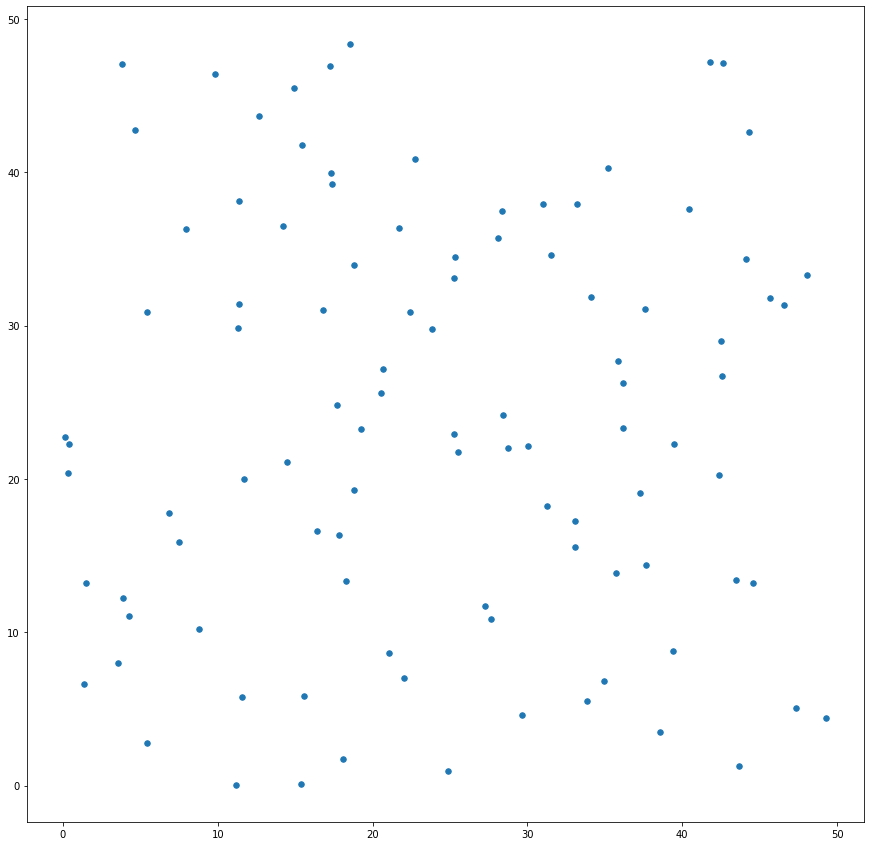

In [149]:
plt.figure(figsize=(15, 15))
plt.scatter(Xs, Ys, s = 30)

In [169]:
Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
clusters = []
dead = []
for i in range(1501):
    clusters = []
    for node in Nodes:
        node.elect(i, clusters)
    if len(clusters) == 0:
        print(T(i), "hello")
        continue
    for node in Nodes:
        node.select(i, clusters)
    #print(Nodes[90].energy)
    for j in range(num_nodes):
        if j not in dead:
            Nodes[j].send()
            if Nodes[j].die:
                dead.append(j)
    if i%100 == 0:
        print(i, len(dead))

0 0
100 0
200 0
0.14285714285714288 hello
300 0
400 0
0.1666666666666667 hello
0.1666666666666667 hello
500 0
0.05882352941176471 hello
600 0
700 0
0.07142857142857144 hello
800 0
1.0000000000000013 hello
900 0
0.09090909090909091 hello
0.06666666666666667 hello
0.052631578947368425 hello
1000 0
0.1 hello
1100 0
0.33333333333333354 hello
1200 0
0.33333333333333354 hello
0.052631578947368425 hello
1300 0
0.07142857142857144 hello
0.5000000000000001 hello
1400 1
0.05882352941176471 hello
0.06666666666666667 hello
1500 11


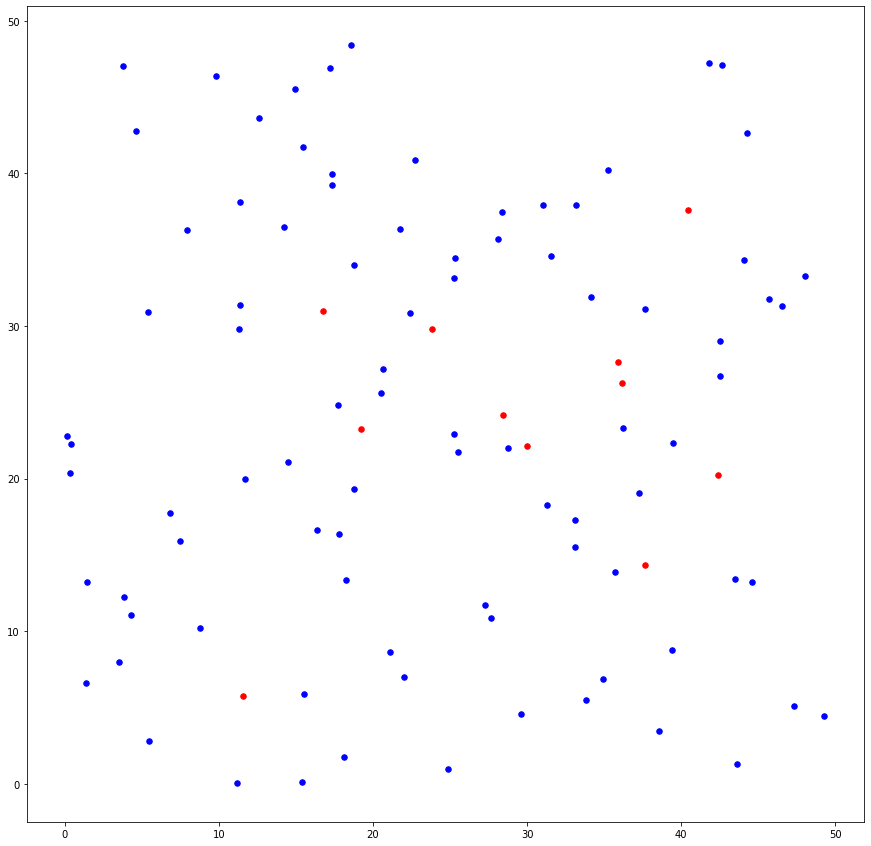

In [170]:
plt.figure(figsize=(15, 15))
dead_X = []
dead_Y = []
undead_X = []
undead_Y = []
for i in range(num_nodes):
    if i in dead:
        dead_X.append(Xs[i])
        dead_Y.append(Ys[i])
    else:
        undead_X.append(Xs[i])
        undead_Y.append(Ys[i])
plt.scatter(dead_X, dead_Y, s = 30, color = 'red')
plt.scatter(undead_X, undead_Y, s = 30, color = 'blue')

In [167]:
print(len(dead))

52
